In [1]:
#import duckdb
#con = duckdb.connect(database=':memory:')
#con.execute("INSTALL sqlite;")
#con.execute("LOAD sqlite;")
#con.execute("CALL sqlite_attach('data/2022-12-23-ecas-export.db');")
#con.execute("PRAGMA show_tables;")
#con.fetchall()

In [2]:
#con.execute("DESCRIBE android_metadata;")
#con.fetchall()

In [3]:
#import sqlalchemy 

In [4]:
import duckdb
import pandas as pd
import sqlalchemy
# No need to import duckdb_engine
#  SQLAlchemy will auto-detect the driver needed based on your connection string!

# Import ipython-sql Jupyter extension to create SQL cells
%load_ext sql
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

In [5]:
%sql duckdb:///:memory:

In [6]:
%%sql

-- SQLite Scanner
-- https://duckdb.org/docs/extensions/sqlite_scanner.html
-- TODO: perhaps consider SET GLOBAL sqlite_all_varchar=true;
--       to avoid things getting read as blob
INSTALL sqlite;
LOAD sqlite;

""


In [7]:
%%sql

CALL sqlite_attach('data/2022-12-24-ecas-export.db');
PRAGMA show_tables;

,name
0,android_metadata
1,meter
2,reading


In [8]:
%%sql 

SELECT * FROM meter;

,_id,name,units,comment,vsf,tsf,cost,fcost,invert,vmsetup,type,currency,scaling,phyunits,bidir,prod
0,1,b'Strom',b'',b'',b'50',b'50',b'',b'',b'0',None,b'0',b'$',b'1.0',b'',b'0',b'0'
1,2,b'W\xc3\xa4rmestrom 18.2',b'',b'',b'50',b'50',b'',b'',b'0',None,b'0',b'$',b'1.0',b'',b'0',b'0'
2,3,b'W\xc3\xa4rmestrom 18.1',b'',b'',b'50',b'50',b'',b'',b'0',None,b'0',b'$',b'1.0',b'',b'0',b'0'
3,4,b'Wasser',b'',b'',b'50',b'50',b'',b'',b'0',None,b'0',b'$',b'1.0',b'',b'0',b'0'
4,5,b'L\xc3\xbcftungsanlage',b'',b'',b'50',b'50',b'',b'',b'0',None,b'0',b'$',b'1.0',b'',b'0',b'0'
5,6,b'Waschmaschine',b'',b'',b'50',b'50',b'',b'',b'0',None,b'0',b'$',b'1.0',b'',b'0',b'0'
6,7,b'Geschirrsp\xc3\xbcler',b'',b'',b'50',b'50',b'',b'',b'0',None,b'0',b'$',b'1.0',b'',b'0',b'0'
7,8,b'Offen',b'',b'',b'50',b'50',b'',b'',b'0',None,b'0',b'$',b'1.0',b'',b'0',b'0'
8,9,b'Reset',b'',b'',b'50',b'50',b'',b'',b'0',None,b'0',b'$',b'1.0',b'',b'0',b'0'
9,10,b'Nachladen',b'',b'',b'50',b'50',b'',b'',b'0',None,b'0',b'$',b'1.0',b'',b'0',b'0'


In [9]:
%%sql 

-- Blob Functions, because most columns get read as blob
-- https://duckdb.org/docs/sql/functions/blob
CREATE OR REPLACE VIEW strom AS 
SELECT meterid, decode(date)::DATETIME AS date, decode(value)::INT AS value 
FROM reading WHERE meterid = 1
;

""


How to use SQLAlchemy and ipython-sql to write sql against DuckDB directly in Jupyter
https://duckdb.org/docs/guides/python/jupyter.html


In [10]:
%%sql 

my_df << SELECT 'Off and flying!' as a_duckdb_column

Returning data to local variable my_df


-- date_sub(): The number of complete partitions between the times
-- https://duckdb.org/docs/sql/functions/time.html

In [11]:
%%sql 

strom_df << SELECT 
  *, 
  date_sub('minute', lag(date) over(order by date), date) AS minutes, 
  value - lag(value) over(order by date) AS consumption,
  24.0 * 60.0 * consumption / minutes AS consumption_per_day
FROM strom
ORDER BY date
;

Returning data to local variable strom_df


In [12]:
strom_df

,meterid,date,value,minutes,consumption,consumption_per_day
0,1,2020-11-30 07:07:00,12162,NaN,NaN,NaN
1,1,2020-11-30 17:35:00,12165,628.0,3.0,6.878981
2,1,2020-11-30 23:59:00,12168,384.0,3.0,11.250000
3,1,2020-12-01 07:18:00,12170,439.0,2.0,6.560364
4,1,2020-12-01 14:23:00,12173,425.0,3.0,10.164706
...,...,...,...,...,...,...
350,1,2022-12-23 10:39:00,18701,1628.0,9.0,7.960688
351,1,2022-12-23 13:03:00,18704,144.0,3.0,30.000000
352,1,2022-12-23 17:47:00,18707,284.0,3.0,15.211268
353,1,2022-12-24 07:44:00,18711,837.0,4.0,6.881720


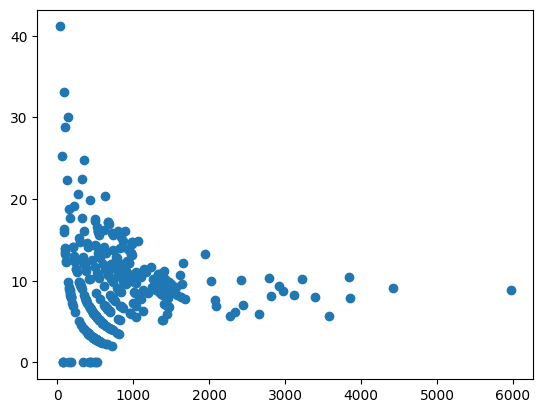

In [13]:

strom_df = strom_df.query("minutes < 10000")

from matplotlib import pyplot
pyplot.scatter(strom_df["minutes"], strom_df["consumption_per_day"])

In [14]:
import plotly.express as px
fig = px.scatter(strom_df, x="minutes", y="consumption_per_day", hover_data=['date'],
marginal_x="histogram", marginal_y="histogram")
fig.show()

In [22]:
import pandas as pd
from numpy import nansum

minute = pd.date_range(start=min(strom_df['date']), end=max(strom_df['date']), freq='min')

minute_df = pd.DataFrame(dict(date = minute))
minute_df = minute_df.merge(strom_df, on='date', how='left')
minute_df['day'] = minute_df['date'].dt.date
minute_df['hour'] = minute_df['date'].dt.hour
minute_df['minute'] = minute_df['date'].dt.minute

hour_df = minute_df.groupby(['day', 'hour']).agg({'value': ['max'], 'minutes': 'sum'})
hour_df = minute_df.groupby(['day', 'hour']).agg({'value': ['max'], 'minutes': 'sum'})

fig = px.scatter(hour_df, x='index', y='consumption_per_day')
fig.show()


value minutes
                     max     sum
day        hour                 
2020-11-30 17    12165.0   628.0
           18        NaN     0.0
           19        NaN     0.0
           20        NaN     0.0
           21        NaN     0.0
...                  ...     ...
2022-12-24 6         NaN     0.0
           7     18711.0   837.0
           8         NaN     0.0
           9         NaN     0.0
           10    18713.0   153.0

[18090 rows x 2 columns]